In [12]:
import os
import pickle
import numpy as np
import xml.etree.ElementTree as ET
import random
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
class DataLoader():
    def __init__(self, batch_size=50, tsteps=300, scale_factor = 10, U_items=10, limit = 500, min_length = 5, alphabet="default"):
        self.data_dir = "./data"
        self.alphabet = alphabet
        self.min_length = min_length
        
        self.batch_size = batch_size
        self.tsteps = tsteps
        self.scale_factor = scale_factor # divide data by this factor
        self.limit = limit # removes large noisy gaps in the data
        self.U_items = U_items

        data_file = os.path.join(self.data_dir, "strokes_training_data.pkl") # pickle 
        stroke_dir = self.data_dir+"/lineStrokes"
        ascii_dir = self.data_dir+"/ascii"

        if not (os.path.exists(data_file)) :
            print("creating training data pkl file from raw source")
            self.preprocess(stroke_dir, ascii_dir, data_file)

        self.load_preprocessed(data_file)
        self.reset_batch_pointer()

    def preprocess(self, stroke_dir, ascii_dir, data_file):
        # create data file from raw xml files from iam handwriting source.
        print("Parsing dataset...")
        
        # build the list of xml files
        filelist = []
        # Set the directory you want to start from
        rootDir = stroke_dir
        for dirName, subdirList, fileList in os.walk(rootDir):
            for fname in fileList:
                filelist.append(dirName+"/"+fname)

        # function to read each individual xml file
        def getStrokes(filename): # returns a list of strokes, where one stroke is a list of points, normalized somehow with a x and y offset
            tree = ET.parse(filename)
            root = tree.getroot() # what is the root here? 

            result = []

            x_offset = 1e20
            y_offset = 1e20
            y_height = 0
            for i in range(1, 4):
                x_offset = min(x_offset, float(root[0][i].attrib['x']))
                y_offset = min(y_offset, float(root[0][i].attrib['y']))
                y_height = max(y_height, float(root[0][i].attrib['y']))
            y_height -= y_offset
            x_offset -= 100
            y_offset -= 100

            for stroke in root[1].findall('Stroke'):
                points = []
                for point in stroke.findall('Point'):
                    points.append([float(point.attrib['x'])-x_offset,float(point.attrib['y'])-y_offset])
                result.append(points)
            return result
        
        # function to read each individual xml file
        def getAscii(filename, line_number): # get the ascii for a particular line number
            with open(filename, "r") as f:
                s = f.read()
            s = s[s.find("CSR"):]
            if len(s.split("\n")) > line_number+2:
                s = s.split("\n")[line_number+2]
                return s
            else:
                return ""
                
        # converts a list of arrays into a 2d numpy int16 array
        def convert_stroke_to_array(stroke):
            n_point = 0 # total number of "points" (x or y) in a stroke
            for i in range(len(stroke)):
                n_point += len(stroke[i]) 
            stroke_data = np.zeros((n_point, 3), dtype=np.int16)

            prev_x = 0
            prev_y = 0
            counter = 0

            for j in range(len(stroke)): # for each point
                for k in range(len(stroke[j])): # for each x/y value in a point
                    stroke_data[counter, 0] = int(stroke[j][k][0]) - prev_x
                    stroke_data[counter, 1] = int(stroke[j][k][1]) - prev_y
                    prev_x = int(stroke[j][k][0])
                    prev_y = int(stroke[j][k][1])
                    stroke_data[counter, 2] = 0
                    if (k == (len(stroke[j])-1)): # end of stroke
                        stroke_data[counter, 2] = 1
                    counter += 1
            return stroke_data

        # build stroke database of every xml file inside iam database
        strokes = []
        asciis = []
        for i in range(len(filelist)):
            if (filelist[i][-3:] == 'xml'):
                stroke_file = filelist[i]
#                 print 'processing '+stroke_file
                stroke = convert_stroke_to_array(getStrokes(stroke_file))
                
                ascii_file = stroke_file.replace("lineStrokes","ascii")[:-7] + ".txt"
                line_number = stroke_file[-6:-4]
                line_number = int(line_number) - 1
                ascii = getAscii(ascii_file, line_number)
                if len(ascii) > min_length: # why does length of line matter here
                    strokes.append(stroke)
                    asciis.append(ascii)
                else:
                    print("======>>>> Line length was too short. Line was: " + ascii)
                
        assert(len(strokes)==len(asciis)), "There should be a 1:1 correspondence between stroke data and ascii labels."
        f = open(data_file,"wb")
        pickle.dump([strokes,asciis], f, protocol=2)
        f.close()
        print("Finished parsing dataset. Saved {} lines".format(len(strokes)))


    def load_preprocessed(self, data_file):
        f = open(data_file,"rb")
        [self.raw_stroke_data, self.raw_ascii_data] = pickle.load(f)
        f.close()

        # goes thru the list, and only keeps the text entries that have more than tsteps points
        self.stroke_data = []
        self.ascii_data = []
        counter = 0

        for i in range(len(self.raw_stroke_data)):
            data = self.raw_stroke_data[i]
            if len(data) > (self.tsteps+2):
                # removes large gaps from the data
                data = np.minimum(data, self.limit)
                data = np.maximum(data, -self.limit)
                data = np.array(data,dtype=np.float32)
                data[:,0:2] /= self.scale_factor
                
                self.stroke_data.append(data)
                self.ascii_data.append(self.raw_ascii_data[i])

        # minus 1, since we want the ydata to be a shifted version of x data
        self.num_batches = int(len(self.stroke_data) / self.batch_size)
        print("Loaded dataset:")
        print("   -> {} individual data points".format(len(self.stroke_data)))
        print("   -> {} batches".format(self.num_batches))

    def next_batch(self):
        # returns a randomised, tsteps sized portion of the training data
        x_batch = []
        y_batch = []
        ascii_list = []
        for i in range(self.batch_size):
            data = self.stroke_data[self.idx_perm[self.pointer]]
            x_batch.append(np.copy(data[:self.tsteps]))
            y_batch.append(np.copy(data[1:self.tsteps+1]))
            ascii_list.append(self.ascii_data[self.idx_perm[self.pointer]])
            self.tick_batch_pointer()
        one_hots = [self.one_hot(s) for s in ascii_list]
        return x_batch, y_batch, ascii_list, one_hots
    
    def one_hot(self, s):
        #index position 0 means "unknown"
        if self.alphabet is "default":
            alphabet = " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"
        seq = [alphabet.find(char) + 1 for char in s]
        if len(seq) >= self.U_items:
            seq = seq[:self.U_items]
        else:
            seq = seq + [0]*(self.U_items - len(seq))
        one_hot = np.zeros((self.U_items,len(alphabet)+1))
        one_hot[np.arange(self.U_items),seq] = 1
        return one_hot

    def tick_batch_pointer(self):
        self.pointer += 1
        if (self.pointer >= len(self.stroke_data)):
            self.reset_batch_pointer()
    def reset_batch_pointer(self):
        self.idx_perm = np.random.permutation(len(self.stroke_data))
        self.pointer = 0
        print("pointer reset")

In [15]:
batch_size = 5
tsteps = 700
data_scale = 50
U_items = int(tsteps/20)
min_length = 5
data_loader = DataLoader(batch_size=batch_size, tsteps=tsteps, \
                         scale_factor=data_scale, U_items=U_items, alphabet="default", min_length=min_length)


creating training data pkl file from raw source
Parsing dataset...
======>>>> Line length was too short. Line was: ago."
======>>>> Line length was too short. Line was: on."
======>>>> Line length was too short. Line was: do I?
======>>>> Line length was too short. Line was: She
======>>>> Line length was too short. Line was: act."
======>>>> Line length was too short. Line was: mass.
======>>>> Line length was too short. Line was: to do
======>>>> Line length was too short. Line was: see. 
======>>>> Line length was too short. Line was: days.
======>>>> Line length was too short. Line was: 25 s.
======>>>> Line length was too short. Line was: it.
======>>>> Line length was too short. Line was: too?
======>>>> Line length was too short. Line was: back.
======>>>> Line length was too short. Line was: m
======>>>> Line length was too short. Line was: acid.
======>>>> Line length was too short. Line was: else.
======>>>> Line length was too short. Line was: read.
======>>>> Line length wa

In [16]:
def line_plot(strokes, title):
    plt.figure(figsize=(20,2))
    eos_preds = np.where(strokes[:,-1] == 1)
    eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
    for i in range(len(eos_preds)-1):
        start = eos_preds[i]+1
        stop = eos_preds[i+1]
        plt.plot(strokes[start:stop,0], strokes[start:stop,1],'b-', linewidth=2.0)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

X BATCH [array([[ 3.34,  7.44,  0.  ],
       [-0.14, -0.04,  0.  ],
       [-0.08, -0.08,  0.  ],
       ...,
       [ 0.18, -0.3 ,  0.  ],
       [ 0.14, -0.28,  0.  ],
       [ 0.16, -0.28,  0.  ]], dtype=float32), array([[ 5.52,  3.54,  0.  ],
       [-0.26, -0.02,  0.  ],
       [-0.36, -0.1 ,  0.  ],
       ...,
       [ 0.42,  0.26,  0.  ],
       [ 0.48, -0.04,  0.  ],
       [ 0.68, -0.14,  0.  ]], dtype=float32), array([[ 3.76,  3.6 ,  0.  ],
       [-0.02,  0.08,  0.  ],
       [-0.02,  0.  ,  0.  ],
       ...,
       [ 1.2 , -2.24,  0.  ],
       [ 0.  ,  0.  ,  0.  ],
       [-0.02,  0.  ,  0.  ]], dtype=float32), array([[ 4.1 ,  8.04,  0.  ],
       [-0.02,  0.  ,  0.  ],
       [-0.06,  0.08,  0.  ],
       ...,
       [ 0.02,  0.46,  0.  ],
       [ 0.  ,  0.32,  0.  ],
       [-0.02,  0.2 ,  0.  ]], dtype=float32), array([[ 2.  ,  2.82,  0.  ],
       [ 0.  ,  0.02,  0.  ],
       [ 0.02,  0.08,  0.  ],
       ...,
       [ 0.08, -0.1 ,  0.  ],
       [ 0.  , -0.26,  

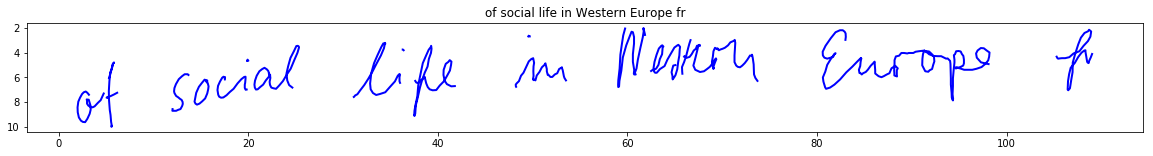

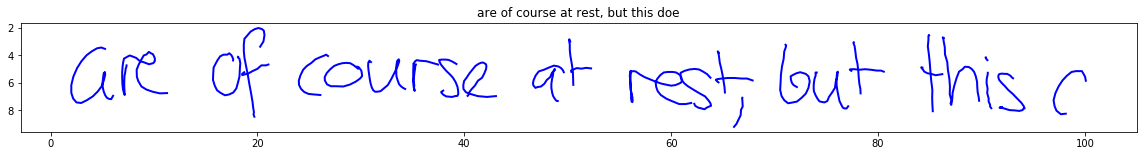

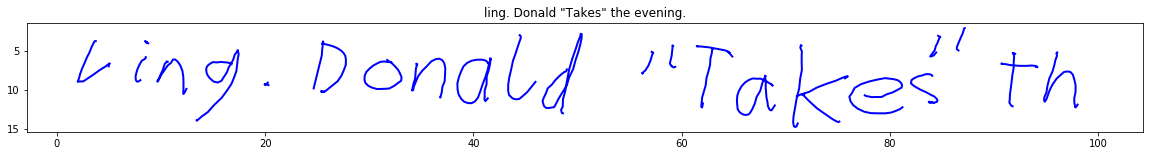

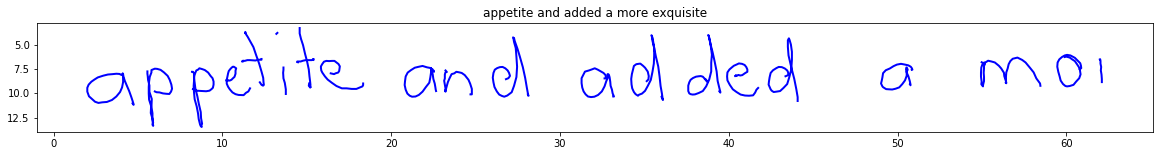

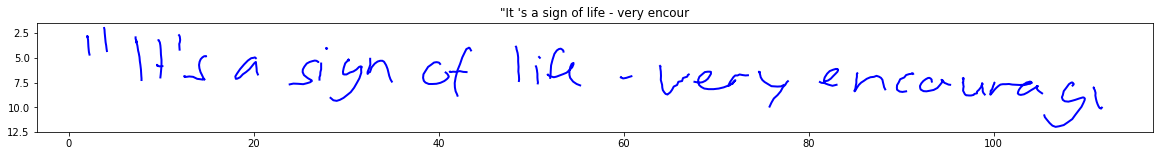

In [24]:
x, y, s, c = data_loader.next_batch()
print("X BATCH", x)
print("Y BATCH", y)
print("ASCII", s)
print("ONE HOT", c)
print(data_loader.pointer)
for i in range(batch_size):
    r = x[i]
    strokes = r.copy()
    strokes[:,:-1] = np.cumsum(r[:,:-1], axis=0)
    line_plot(strokes, s[i][:U_items])

In [20]:
# with open(os.path.join('data', 'styles.p'),'r') as f:
#     style_strokes, style_strings = pickle.load(f)
    
# for i in range(len(style_strokes)):
#     strokes = style_strokes[i]
#     strokes[:,:-1] = np.cumsum(strokes[:,:-1], axis=0)
#     line_plot(strokes, "Style #{}: {}".format(i+1, style_strings[i]))